In [1]:
import os
from pprint import pprint
from csv import reader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,v_measure_score
from sklearn import linear_model,preprocessing

from scipy.optimize import minimize, Bounds
from scipy.linalg import orth, eigh

import statsmodels.api
import statsmodels as sm

import anndata
import scanpy

from glmpca import glmpca

import csv

from tqdm import trange

In [2]:
# Load Belayer functions

import sys

sys.path.append('src')
from utils_IO import *

# from simpleharmonic import *
from harmonic import *
from region_cost_fun import *
from dprelated import *
from dp_post_processing import *
from general_helper_funcs import * # Cong added the helper function script from belayer-develop to belayer repo
from precompute_likelihood import *
from dp_linear_boundary import *
import svg

# Dataset 1: DLPFC (10x Visium)

## Belayer mode 1: Assume layer boundaries are lines [TODO CONG]

**Step 0: load data, GLM-PCA**

In [3]:
# OPTION 1: load from 10x folder
# input_10x_folder='INSERT/PATH/TO/FOLDER/{}'.format(sample)
# count, coords, barcodes, gene_labels=read_input_10xdirectory(input_10x_folder)
# G,N= count.shape

# OPTION 2: load your own adata file
# load your own file
sample='151508'
H5AD_FILE_LOCATION="/n/fs/ragr-data/users/congma/Codes/spatial_embedding/data/{}/sample_{}.h5ad".format(sample,sample)
adata = anndata.read_h5ad(H5AD_FILE_LOCATION)

gene_labels=np.array(adata.var.index)
count=adata.layers['count'].T
G,N=count.shape
coords=adata.obsm["X_pos"]



In [4]:
# OPTION 1: generate GLM-PCA and save to file

# glmpca_res = glmpca.glmpca(count, 2*7, fam="poi", penalty=10, verbose=True)
# F_glmpca = glmpca_res['factors']
# np.save('INSERT/PATH/', F_glmpca)

# OPTION 2: load pre-computed GLM-PCs

# replace with your own file
PRESAVED_GLMPCA_FILE='/n/fs/ragr-research/projects/network-mutations/spatial_trans/F_glmpca_2d/F_glmpca_2d_151508_penalty_10_trial_0.npy'
F_glmpca=np.load(PRESAVED_GLMPCA_FILE+''.format(sample,trial))


NameError: name 'trial' is not defined

**Step 1: pre-compute losses for all combinations of linear boundaries**

Note: this takes a long time, so we suggest running on cluster. 
(But once you run this once you do not have to run again)

In [ ]:
# FOLDER_TO_SAVE_LOSSES_IN="" # add the folder to save precomputation results in

# max_nlayers=10 #maximum number of layers
# num_batches=10000 # number of batches to split computation
# batch_id=0 # TODO (CONG) insert description

# # fill in the full hexagon geometry
# fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)
# F_full_glmpca = np.ones((fullpoints.shape[0], F_glmpca.shape[1])) * np.nan
# F_full_glmpca[in_tissue] = F_glmpca

# llf = lossfunction(F_full_glmpca.T, fullpoints[:,0], fullpoints[:,1], total_num_cluster=max_nlayers,  platform="Visium")
# llf.F_glmpca_2d_poisson = F_full_glmpca

# sorted_boundary = get_sorted_boundary_points(fullpoints) # TODO CONG: this function does not exist???? # Added the help function script

# # get boundary tuples
# boundary_tuples = get_full_boundary_tuples_from_sorted(sorted_boundary)
# logger.info("There are {} tuples of boundary end points.".format( len(boundary_tuples) ))
# boundary_triples = get_full_boundary_triples_from_sorted(sorted_boundary)
# logger.info("There are {} triples of boundary end points for half circle regions.".format(len(boundary_triples)))

# # output dictionary
# pre_saving = {}

# # batch for region bounded by two lines
# s = int( np.round(len(boundary_tuples) / num_batches * batch_id) )
# t = int( np.round(len(boundary_tuples) / num_batches * (batch_id+1)) )

# for r in trange(s, t):
#     i, j, k, m = boundary_tuples[r]
#     this_loss = llf.eval_loss(sorted_boundary[i], sorted_boundary[j], b2_endp1=sorted_boundary[k],  
#                               b2_endp2=sorted_boundary[m], loss='Gaussian')
#     pre_saving[ boundary_tuples[r] ] = this_loss
    
# # batch for region bounded by one line and tissue boundary
# s = int( np.round(len(boundary_triples) / num_batches * batch_id) )
# t = int( np.round(len(boundary_triples) / num_batches * (batch_id+1)) )

# for r in trange(s, t):
#     i, j, k = boundary_triples[r]
#     this_loss = llf.eval_loss(sorted_boundary[i], sorted_boundary[j], b2_endp1=sorted_boundary[k], loss='Gaussian')
#     if k == i+1:
#         pre_saving[ (i,j,np.inf,np.inf) ] = this_loss
#     else:
#         pre_saving[ (np.inf,np.inf, i,j) ] = this_loss
# pickle.dump(pre_saving, open(f"{FOLDER_TO_SAVE_LOSSES_IN}_pre_saving_{batch_id}_{num_batches}.pkl", 'wb'))


In [5]:
##### this is using the utility function in precompute_likelihood.py #####

FOLDER_TO_SAVE_LOSSES_IN="" # add the folder to save precomputation results in

max_nlayers=10 #maximum number of layers

p = precompute_class(F_glmpca, coords, max_nlayers, FOLDER_TO_SAVE_LOSSES_IN) # initialize the object that contains all information for precomputing likelihoods


# OPTION 1: no parallelization

p.precompute_likelihood(F_glmpca, coords, max_nlayers, FOLDER_TO_SAVE_LOSSES_IN)


# OPTION 2: parallel using python
# Split the set of all line-bounded regions into num_batches for precomputing likelihoods. The per-region likelihoods of each batch will be stored in a separate file and need to be merged.
# import multiprocessing

# n_processes = 10 # number processes to use in multi-processing.
# num_batches = 1000 # number of batches to split the likelihood precomputation
# p.num_batches = num_batches
# pool = multiprocessing.Pool(processes = n_processes)
# outputs = pool.map(p.precompute_likelihood, np.arange(num_batches))
# p.combine_precomputed_likelihoods()


# OPTION 3: parallel by submitting multiple jobs in slurm



100%|██████████| 204/204 [00:44<00:00,  4.56it/s]
2022-06-25 08:36:13 - INFO - There are 140117502 tuples of boundary end points.
100%|██████████| 204/204 [00:00<00:00, 16459.64it/s]
2022-06-25 08:36:13 - INFO - There are 41412 triples of boundary end points for half circle regions.


**Step 2: run DP using pre-computed losses**

In [ ]:
# FOLDER_TO_SAVE_DP="" # add folder to save results of DP
# L=6 # number of layers to learn

# # load pre-saved losses
# pre_saved_loss={}
# tmp = pickle.load(open(f"{FOLDER_TO_SAVE_LOSSES_IN}_pre_saving.pkl", 'rb'))
# pre_saved_loss.update(tmp)

# # create wrapper for linear DP
# loss_wrapper = gen_loss_wrapper(pre_saved_loss)

# # initialize arrays for endpoints, loss, runtime
# arr_layers, arr_loss = [list(np.zeros(args.nlayers + 1)) for _ in range(2)]

# # create DP matrix
# dp_mat = construct_dp_mat(sorted_boundary, args.nlayers, loss_wrapper)

# # for number of layers from 1 to max_layers, find best layer boundaries
# for num_layers in range(1, L + 1):
#     res = find_first_layer(dp_mat, len(sorted_boundary), args.nlayers)
#     loss, layers = res
    
#     # order layer boundaries using func above
#     layers = [[sorted_boundary[ele[0]], sorted_boundary[ele[1]]] for ele in layers]
#     ordered_layers = order_layer_boundaries(layers)
    
#     # save layer boundaries, loss, runtime
#     arr_layers[num_layers] = ordered_layers
#     arr_loss[num_layers] = loss
    
# # save loss and ordered layer boundaries 
# arr_loss_np = np.asarray(arr_loss, dtype=object)
# arr_layers_np = np.asarray(arr_layers, dtype=object)

# np.save(f'{FOLDER_TO_SAVE_DP}/non_init_loss.npy', arr_loss_np, allow_pickle=True, fix_imports=True)
# np.save(f'{FOLDER_TO_SAVE_DP}/non_init_layers.npy', arr_layers_np, allow_pickle=True, fix_imports=True)

In [6]:
PREFIX_TO_SAVE_DP = "" # folder to save the optimal layer boundaries and likelihood values
arr_loss_np, arr_layers_np = run_dp_linear_boundary(FOLDER_TO_SAVE_LOSSES_IN, p.sorted_boundary, max_nlayers, PREFIX_TO_SAVE_DP)


9 level index: 100%|██████████| 204/204 [09:18<00:00,  2.74s/it]


Finding layer boundary 10: 100%|██████████| 204/204 [00:00<00:00, 7905.23it/s]


**Step 3 (Optional): Spatially varying gene analysis** [TODO CONG]

In [7]:
# restrict genes
idx_kept=svg.select_commonly_expressed_genes(count, q=0.85, threshold=0, pooling=False)
print("number of kept genes = {}".format(len(idx_kept)))

number of kept genes = 2031


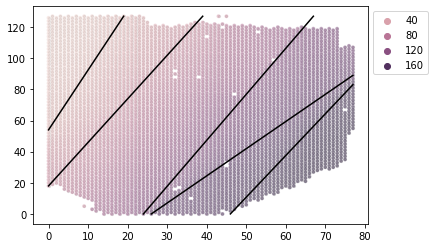

In [27]:
# # pre-load the DP boundaries

# # replace below with correct location
# LAYER_FOLDER="/n/fs/ragr-research/projects/layered-tissues/belayer-development/examples/samples_code/"
# all_dp_boundaries = np.load(LAYER_FOLDER + "non_init_layers.npy", allow_pickle=True)

# L=6 # number of layers
# dp_boundaries = all_dp_boundaries[L-1]

# # create loss function
# llf = lossfunction(F_glmpca.T, coords[:,0], coords[:,1], total_num_cluster=6, platform="Visium")
# llf.F_glmpca_2d_poisson = F_glmpca

# # TODO (cong) replace below with single function call

# ##### harmonic interpolation for each layer #####
# ##### without initialization versionn #####
# interpolation = np.ones(coords.shape[0]) * np.nan
# dp_labels = np.ones(coords.shape[0]) * np.nan
# shift = 0
# for i in range(len(dp_boundaries) + 1):
#     if i > 0 and i < len(dp_boundaries):
#         b1_endp1 = dp_boundaries[i-1][0]
#         b1_endp2 = dp_boundaries[i-1][1]
#         b2_endp1 = dp_boundaries[i][0]
#         b2_endp2 = dp_boundaries[i][1]
#         # get indices of points bounded by the two lines
#         idx_b1, idx_b2, idx_inside = llf.interpolation.get_spots_index_within_region(b1_endp1, b1_endp2, b2_endp1, b2_endp2)
#         # harmonic interpolation
#         proj_b1, proj_b2, proj_inside = llf.interpolation.interpolate_two_boundaries(idx_b1, idx_b2, idx_inside)
#         # concatenate indices and interpolation
#         index = np.concatenate([idx_b1,idx_b2,idx_inside])
#         proj = np.concatenate([proj_b1, proj_b2, proj_inside])
#     else:
#         b1_endp1 = dp_boundaries[i][0] if i == 0 else dp_boundaries[i-1][0]
#         b1_endp2 = dp_boundaries[i][1] if i == 0 else dp_boundaries[i-1][1]
#         # manually set b2_endp1 to indicate which side of half circle to perform diffusion, but it should be consistent for all 4 slices
#         b2_endp1 = (0,126) if i == 0 else (77, 1)
#         # get indices of points in half circle
#         idx_b1, idx_inside = llf.interpolation.get_spots_index_within_halfcircle(b1_endp1, b1_endp2, b2_endp1)
#         # diffusion
#         proj_b1, proj_inside = llf.interpolation.diffusion_harmonic(idx_b1, idx_inside)
#         index = np.concatenate( [idx_b1, idx_inside] )
#         proj = np.concatenate( [proj_b1, proj_inside] )
#         if i == len(dp_boundaries):
#             proj = np.max(proj) - proj
#     # add a shift to the harmonic interpolation so that they are larger than the previous layer
#     interpolation[ index ] = shift + proj
#     dp_labels[index] = i
#     shift += np.max(proj)
    
# plt.scatter(coords[:,0], coords[:,1], c="grey", s=5, alpha=0.2)
# sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=interpolation, s=15, alpha=0.5)
# for endpoints in dp_boundaries:
#     b1, b2 = endpoints
#     plt.plot([b1[0], b2[0]], [b1[1], b2[1]], c="black")
# plt.legend(loc="upper left", bbox_to_anchor=(1,1))
# plt.show()





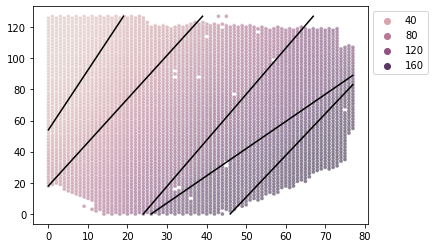

In [9]:
dp_boundaries = arr_layers_np[5]
depth, dp_labels = get_depth_from_linear_boundaries(p.llf.interpolation, dp_boundaries, p.in_tissue)

plt.scatter(coords[:,0], coords[:,1], c="grey", s=5, alpha=0.2)
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=depth, s=15, alpha=0.5)
for endpoints in dp_boundaries:
    b1, b2 = endpoints
    plt.plot([b1[0], b2[0]], [b1[1], b2[1]], c="black")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [12]:
# get slopes, offsets
slope_offsets=svg.segmented_poisson_regression(count[idx_kept,:], 
                                               np.sum(count,axis=0), 
                                               dp_labels, 
                                               depth)

# For example, the two genes with largest absolute slopes in layer 3: NEFM and HPCAL1
gene_labels[ idx_kept[ np.argsort( np.abs(slope_offsets['slope 2.0']) )[::-1][:2] ] ]

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/env_cellcycle/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/env_cellcycle/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/env_cellcycle/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/env_cellcycle/lib/python3.7/site-packages/sklearn/linear_model/_glm/glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(

array(['ENSG00000100285', 'ENSG00000115756'], dtype=object)

### Belayer mode 2: Assume layer boundaries are _parallel_ lines

**Step 1: run Belayer DP on different rotations of tissue slice**

In [5]:
# Run Belayer DP

# NOTE: results are influenced by different rotation angles
# below we rotate tissue by 0 degrees, ..., 20 degrees
rotation_angle_list=[0,5,10,15,17.5,20]

losses,labels=rotation_dp(F_glmpca.T, coords, use_buckets=True, 
                          num_buckets=150,rotation_angle_list=rotation_angle_list)



 angle: 0
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 5
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 10
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 15
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding se

**Step 2: Model selection for rotation angle and number L of layers**

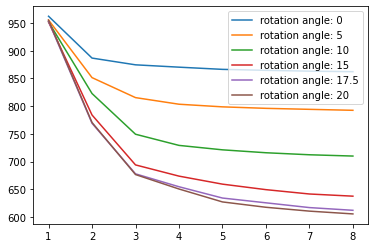

In [6]:
# Model selection - choose best angle and best L

# first, find rotation angle that looks best. Below it is 20.
plot_angle_selection(losses,rotation_angle_list=rotation_angle_list)

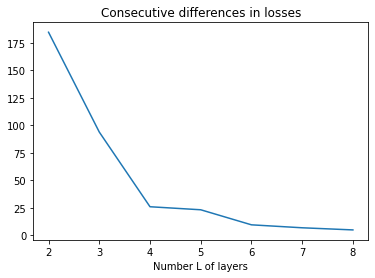

In [7]:
# Then, using that rotation angle, plot consecutive differences and choose approximate elbow
# Below, we select L=6

best_angle=20
plot_consecutive_diffs(losses, best_angle,rotation_angle_list=rotation_angle_list)

**Step 3: Get layer labels from Belayer and plot**

<function rotate_by_theta at 0x7fe257035af0>


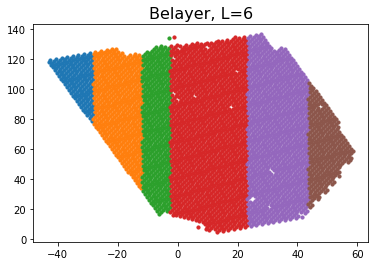

In [8]:
# Plot the labels from Belayer

best_L=6
belayer_labels, belayer_rotated_coords=belayer_output(labels, coords, best_L, best_angle,
                                                   rotation_angle_list=rotation_angle_list)


** Step 4 (optional): spatially varying gene analysis

In [9]:
# filter out low UMI genes
idx_kept=svg.select_commonly_expressed_genes(count, q=0.85, threshold=0, pooling=False)
print("number of kept genes = {}".format(len(idx_kept)))

# get slopes, offsets
slope_offsets=svg.segmented_poisson_regression(count[idx_kept,:], np.sum(count,axis=0), 
                                               belayer_labels, belayer_rotated_coords[:,0])



number of kept genes = 2031


In [12]:
slope_offsets

,intercept 0.0,slope 0.0,intercept 1.0,slope 1.0,intercept 2.0,slope 2.0,intercept 3.0,slope 3.0,intercept 4.0,slope 4.0,intercept 5.0,slope 5.0
0,-7.972960,0.059855,-8.605955,0.023284,-9.803035,-0.080834,-9.150162,0.013839,-8.401987,-0.021450,-5.434744,-0.073715
1,-9.194856,-0.000026,-8.597478,0.041043,-8.692879,0.089460,-9.227165,-0.008738,-9.976980,0.016271,-9.400918,0.007837
2,-9.843707,-0.040185,-9.146309,-0.034895,-8.233032,0.018917,-8.358478,-0.001629,-8.220892,-0.007128,-9.071779,0.011713
3,-8.675974,0.005045,-9.423613,-0.031569,-8.191705,0.104579,-8.485741,-0.006051,-8.697736,0.005089,-9.664315,0.013672
4,-9.329653,-0.021948,-9.230337,-0.021102,-8.682621,0.000419,-8.619582,0.008496,-8.581258,0.001976,-7.569696,-0.020709
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,-5.945980,0.021158,-6.306195,-0.000376,-6.935760,-0.071229,-6.550335,-0.003889,-6.550688,-0.010187,-7.414230,0.000008
2027,-3.827784,0.006653,-3.870980,0.000183,-4.119395,-0.035121,-3.939453,-0.001111,-3.981953,-0.004751,-4.450614,0.001467
2028,-5.807821,0.002546,-5.655721,-0.005657,-5.998766,-0.056912,-5.768734,-0.003174,-5.751485,-0.011276,-7.145973,0.013467
2029,-6.860190,0.056313,-8.904045,-0.018375,-9.130535,-0.058510,-8.861714,0.000342,-9.157069,0.006504,-8.762288,-0.009870


In [22]:
# For example, NEFM and HPCAL1 are the two genes with largest absolute slopes in layer 4 
gene_labels[ idx_kept[ np.argsort( np.abs(slope_offsets['slope 3.0']) )[::-1][:2] ] ]

array(['ENSG00000115756', 'ENSG00000100285'], dtype=object)

### [TODO] Belayer mode 3: assume approximate layer boundaries are given

# Dataset 2: mouse skin wound (10x Visium)

Step 1: load data

In [3]:
input_10x_folder='/n/fs/ragr-data/users/congma/Codes/spatial_embedding/data/SkinWoundPNAS/Visium/V19N18-025_A1/outs/'
count, coords, barcodes, genes=read_input_10xdirectory(input_10x_folder)

G,N=count.shape

# fill in gaps in 10x hexagonal grid
fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)

# get boundary points
boundary_file='/n/fs/ragr-data/users/congma/Codes/belayer-development/reproducibility/skin_wound/list_boundaries.npy'
boundary_list = read_boundary_list(boundary_file, fullpoints)



Step 2: run/load GLMPCA

In [5]:
# OPTION 1: generate GLM-PCA and save to file
# glmpca_res = glmpca.glmpca(count, 2*3, fam="poi", penalty=10, verbose=True)
# F_glmpca = glmpca_res['factors']
# np.save('INSERT/PATH/', F_glmpca)

# OPTION 2: load pre-computed GLM-PCs
F_glmpca=np.load(input_10x_folder+'glmpca_6PC_10.npy')

Step 2: run harmonic interpolation for each pair of consecutive boundaries

In [6]:
# harmonic interpolation
spos = spatialcoord(x = fullpoints[:,0], y = fullpoints[:,1])
har = harmonic(fullpoints, spos.adjacency_mat, np.sqrt(spos.pairwise_squared_dist))
interpolation = har.interpolation_using_list( boundary_list )
interpolated_coords = interpolation[in_tissue]

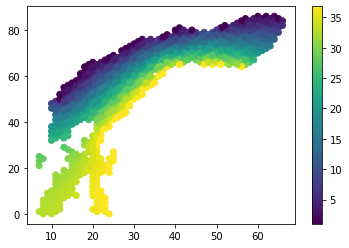

In [7]:
plt.scatter(coords[:,0],coords[:,1],c=interpolated_coords)
plt.colorbar()

Step 3: run DP and get segments

In [12]:
# try my DP code...

L=3
error_mat, segment_map = dp_raw(F_glmpca.T, L, interpolated_coords)

Step 4: get segments from DP and plot labels

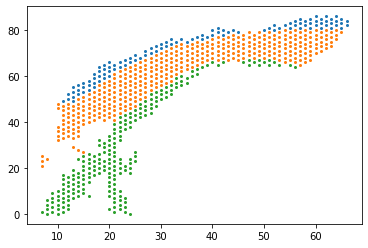

In [19]:
# same as above with my DP
segs = find_segments_from_dp(error_mat, segment_map, L,xcoords=interpolated_coords)
dp_labels = np.zeros(N, dtype=int)
c=0
for seg in segs:
    dp_labels[ seg ] = c
    c+=1

for t in np.unique(dp_labels):
    pts_t=np.where(dp_labels==t)
    plt.scatter(coords[pts_t,0],coords[pts_t,1],s=4)


In [ ]:

# output labels
df_dp_labels = pd.DataFrame({"depth":interpolation, "layer":dp_labels}, index=barcodes)
df_dp_labels.to_csv(args.outprefix + "_layers.txt", sep="\t")
# fitting expression function per gene
selected_genes = select_commonly_expressed_genes(count, interpolation, q=0.75)
totalumi = np.sum(count, axis=0)
df_gene_func = segmented_poisson_regression(count[selected_genes,:], totalumi, dp_labels, interpolation)
df_gene_func.index = genes[selected_genes]
# output per-gene regression parameter
df_gene_func.to_csv(args.outprefix + "_function_coefficients.txt", sep="\t")

# Slide-SeqV2 code